In [58]:
import logging
import os
import gcsfs

from sklearn.decomposition import PCA

from ml_bay12.GCS import GCSLoader
from ml_bay12 import data_prepare

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

import re
from sklearn.linear_model import LogisticRegression

import warnings

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings('ignore')

In [21]:
gcs=GCSLoader(project='open-mafia-ml-bay12',path='om-ml-bay12-storage/dataset/ds_mafia')
post=gcs.get_post()
role=gcs.get_role()

In [22]:
post.head()

,thread_num,user,text,quotes
0,39457,Mephansteras,There was some talk about a beginners mafia ga...,[]
1,39457,Pandarsenic,*Cough*\r\r\r\r\nI'd join.,[]
2,39457,Org,Im in.,[]
3,39457,Mephansteras,"*sigh*\r\r\r\r\n\r\r\r\r\nOk, how about people...",[]
4,39457,Jim Groovester,I... may join. Just to see what the hell is so...,[]


In [23]:
role.head()

,thread_num,user,final_player,role,role_id,uid
0,117173,Captain Ford,Captain Ford,mafia,1.0,117173_Captain_Ford
1,117173,Jim Groovester,Jim Groovester,town,0.0,117173_Jim_Groovester
2,117173,Mr.Zero,Reverie,mafia,1.0,117173_Mr.Zero
3,117173,MrCelt,MrCelt,town,0.0,117173_MrCelt
4,117173,Nabic,Nabic,town,0.0,117173_Nabic


In [24]:
post_test=gcs.get_post(which='test')
role_test=gcs.get_role(which='test')
post["text"]=post["text"].apply(data_prepare.clean)
post_test["text"]=post_test["text"].apply(data_prepare.clean)

In [25]:
users_df=data_prepare.concat_users_text(post)
users_test_df=data_prepare.concat_users_text(post_test)

In [26]:
main_df = data_prepare.get_users_in_game(role, users_df)
main_test_df = data_prepare.get_users_in_game(role_test, users_test_df)

In [27]:
train_data=main_df["text"]
y=main_df["role_id"]
y_test=gcs.get_role_answers()["role_id"]
test_data=main_test_df["text"]

In [31]:
vectorizer = CountVectorizer(min_df=3, stop_words='english')
X_train = vectorizer.fit_transform(train_data).toarray()
X_test=vectorizer.transform(test_data).toarray()
X_train.shape

(478, 7955)

In [32]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

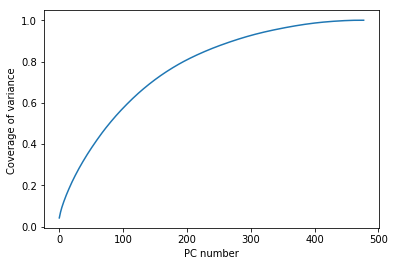

In [33]:
pca = PCA().fit(X_train)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('PC number')
plt.ylabel('Coverage of variance ')
plt.show()

In [34]:
pca = PCA(n_components=250)
pC = pca.fit_transform(X_train)
pCTest=pca.transform(X_test)

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(pC, y, test_size=0.2, random_state=24)

## xgboost

In [38]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold

In [39]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

In [42]:
ald_xgb_model = xgb.XGBClassifier()
ald_xgb_params = [
    {"n_estimators": [230, 250, 270],
     "max_depth": [1, 2, 4],
     "learning_rate": [0.01, 0.02, 0.05]}
]
alg_xgb_grid = GridSearchCV(ald_xgb_model, ald_xgb_params, cv=cv, refit=True, verbose=1, n_jobs=1)
alg_xgb_grid.fit(X_train, y_train)
alg_xgb_best = alg_xgb_grid.best_estimator_
print("Accuracy (xgboost auto): {} with params {}"
      .format(alg_xgb_grid.best_score_, alg_xgb_grid.best_params_))

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:  5.2min finished


Accuracy (xgboost auto): 0.7827225130890052 with params {'learning_rate': 0.02, 'max_depth': 1, 'n_estimators': 270}


In [51]:
preds_class = alg_xgb_best.predict(pCTest)
preds_proba = alg_xgb_best.predict_proba(pCTest)

In [52]:
roc_auc_score(y_test, preds_proba[:,1])

0.5221241145365659

In [53]:
accuracy_score(y_test, preds_class)

0.7671641791044777

In [54]:
accuracy_score(y_test, preds_class, normalize=False)

257

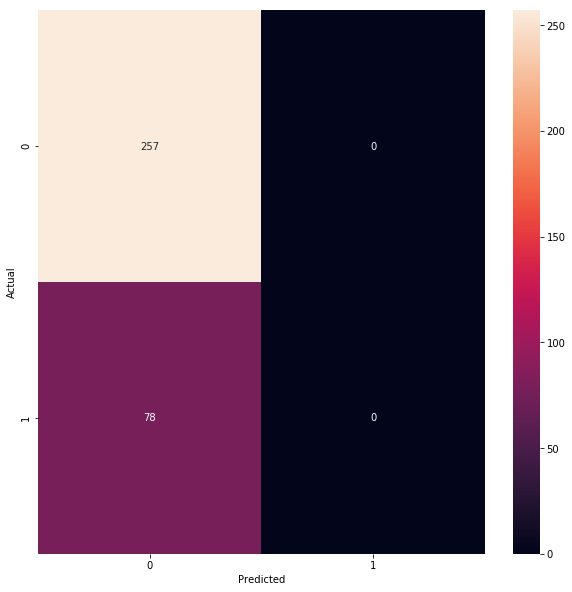

In [56]:
import seaborn as sns
conf_mat = confusion_matrix(y_test, preds_class) 
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## randomForest

In [59]:
alg_frst_model = RandomForestClassifier(random_state=1)
alg_frst_params = [{
    "n_estimators": [350, 400, 450],
    "min_samples_split": [6, 8, 10],
    "min_samples_leaf": [1, 2, 4]
}]
alg_frst_grid = GridSearchCV(alg_frst_model, alg_frst_params, cv=cv, refit=True, verbose=1, n_jobs=-1)
alg_frst_grid.fit(X_train, y_train)
alg_frst_best = alg_frst_grid.best_estimator_
print("Accuracy (random forest auto): {} with params {}"
      .format(alg_frst_grid.best_score_, alg_frst_grid.best_params_))

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  4.6min finished


Accuracy (random forest auto): 0.7801047120418848 with params {'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 350}


In [60]:
preds_class = alg_frst_best.predict(pCTest)
preds_proba = alg_frst_best.predict_proba(pCTest)

In [61]:
roc_auc_score(y_test, preds_proba[:,1])

0.4883767335129203

In [62]:
accuracy_score(y_test, preds_class)

0.764179104477612

In [63]:
accuracy_score(y_test, preds_class, normalize=False)

256

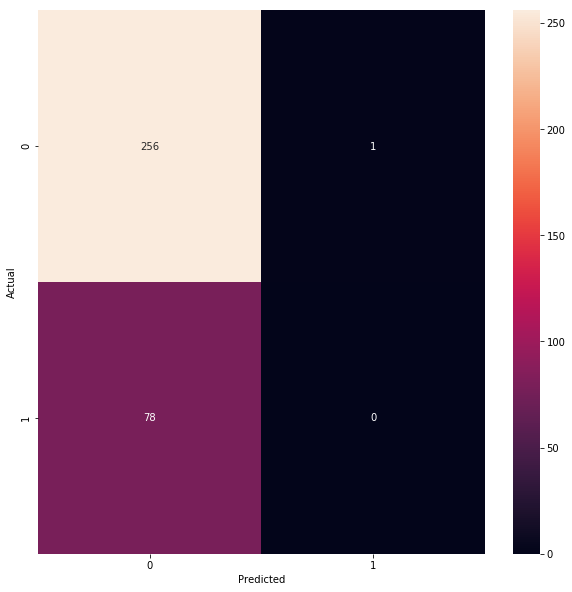

In [64]:
conf_mat = confusion_matrix(y_test, preds_class) 
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()